In [93]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import json
from pprint import pprint
import datetime

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [4]:
# Names of the raw data files
train_dataset = 'train.json'
test_dataset = 'test.json'

# Toggle for making a dev set
make_devset = 1

In [59]:
def separate_data(dataset,data_type):
    data_features=[]
    data_msgtxt=[]
    data_titletxt=[]
    data_subreddits=[]
    data_month=[]
    data_dom=[]
    data_hour=[]
    
    # Create empty array for labels
    if data_type == 'train':
        data_labels=[]
   
    # Loop over the requests
    for request in dataset:
        
        # Get label data (if this is training data)
        if data_type == 'train':
            if request['requester_received_pizza'] == True:
                data_labels.append(1)
            else:
                data_labels.append(0)
                
        parts = []
        
        # Pull out text fields
        data_msgtxt.append(request['request_text_edit_aware'])
        data_titletxt.append(request['request_title'])
        data_subreddits.append(request['requester_subreddits_at_request'])
        
        # Pull out relevant time info
        month = datetime.datetime.fromtimestamp(request['unix_timestamp_of_request']).strftime("%m")
        day_of_month = datetime.datetime.fromtimestamp(request['unix_timestamp_of_request']).strftime("%d")
        hour = datetime.datetime.fromtimestamp(request['unix_timestamp_of_request']).strftime("%H")
        parts.append(int(month))
        parts.append(int(day_of_month))
        parts.append(int(hour))
        
        # Add each data element to the features set
        for element in data_elements:
            parts.append(request[element])
        
        data_features.append(parts)
    
    if data_type == 'train':
        return data_msgtxt, data_titletxt, data_subreddits, np.array(data_features), np.array(data_labels)
    else:
        return data_msgtxt, data_titletxt, data_subreddits, np.array(data_features)

In [1]:
train_data = json.loads(open(train_dataset).read())
test_data = json.loads(open(test_dataset).read())

data_elements=['requester_days_since_first_post_on_raop_at_request', 'requester_account_age_in_days_at_request', 'requester_number_of_posts_on_raop_at_request', 'requester_number_of_posts_at_request', 'requester_upvotes_plus_downvotes_at_request', 'requester_number_of_comments_at_request', 'requester_upvotes_minus_downvotes_at_request','requester_number_of_comments_in_raop_at_request','requester_number_of_subreddits_at_request']

# Set np seed
np.random.seed(0)

# List is mutable, this shuffles permanently
np.random.shuffle(train_data) 

# Split data into train, dev, test
train_raw_data=train_data[num_train/4:]
dev_raw_data=train_data[:num_train/4]
test_raw_data = test_data

# Split each dataset into msgtxt, titletxt, subreddits, features, and labels
train_msgtxt, train_titletxt, train_subreddits, train_features, train_labels = separate_data(train_raw_data,'train')
dev_msgtxt, dev_titletxt, dev_subreddits, dev_features, dev_labels = separate_data(dev_raw_data, 'train')
test_msgtxt, test_titletxt, test_subreddits, test_features = separate_data(test_raw_data, 'test')

# Prepend timestamp data to elements list
data_elements.insert(0, 'request_hour')
data_elements.insert(0, 'request_day_of_month')
data_elements.insert(0, 'request_month')

print train_labels.shape
print len(dev_target)
print test_features.shape

pprint(data_elements)


NameError: name 'json' is not defined

request_month


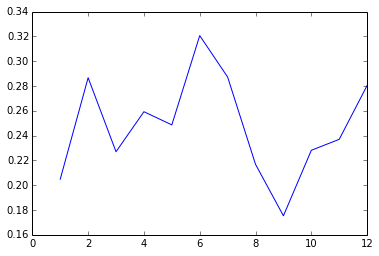

In [140]:
# Graph relationship between feature number and success rate (needs to be worked on, esp using deciles or something)
feature_num = 0

uniq_vals = np.unique(train_features[:,feature_num])
num_success = np.zeros(len(uniq_vals))
num_total = np.zeros(len(uniq_vals))

for i in range(len(train_features)):
    index= np.where(uniq_vals==train_features[i,feature_num])[0][0]
    num_total[index]+=1
    if train_labels[i] == 1:
        num_success[index]+=1

success_rate = np.zeros(len(num_total))

for i in range(len(num_total)):
    success_rate[i] = num_success[i]/num_total[i]

   
plt.plot(np.unique(train_features[:,feature_num]),success_rate)
print data_elements[feature_num]

In [89]:
def vectorize(train_data,dev_data):
    # transform the train data
    vectorizer_train = CountVectorizer()
    #vectorizer_train = TfidfVectorizer()
    v_data_train = vectorizer_train.fit_transform(train_data)
    vocab_train = vectorizer_train.get_feature_names()
    # transform the dev data using the same vocab
    vectorizer_dev = CountVectorizer(vocabulary=vocab_train)
    #vectorizer_dev = TfidfVectorizer(vocabulary=vocab_train)
    v_data_dev = vectorizer_dev.fit_transform(dev_data)
    return v_data_train, v_data_dev, vocab_train

In [6]:
def vectorize_bigram(train_data,dev_data):
    # transform the train data
    vectorizer_train = CountVectorizer(ngram_range=(2,2))
    v_data_train = vectorizer_train.fit_transform(train_data)
    vocab_train = vectorizer_train.get_feature_names()
    # transform the dev data using the same vocab
    vectorizer_dev = CountVectorizer(ngram_range=(2,2),vocabulary=vocab_train)
    v_data_dev = vectorizer_dev.fit_transform(dev_data)
    return v_data_train, v_data_dev, vocab_train

In [7]:
# Get attributes using nnz and shape
def vectorizer_attrs(v_data):
    nonzero = v_data.nnz
    examples = v_data.shape[0]
    distinct_words = v_data.shape[1]
    avg_nonzero = float(nonzero)/examples
    total_entries = examples*distinct_words
    pct_nz_entries = float(nonzero)/total_entries*100
    return "Vocabulary size: " + str(distinct_words) + "\nAverage non-zero features per example: " + str(round(avg_nonzero,1)) + "\nFraction of non-zero entries in the matrix is " + str(nonzero) + "/" + str(total_entries) + " (" + str(round(pct_nz_entries,2)) + "%)"

In [8]:
def log_reg(train_data,train_label,dev_data):
    lor = LogisticRegression(penalty='l2',C=100)
    lor.fit(train_data, train_label)
    lor_pred = lor.predict(dev_data)
    lor_pred_pr = lor.predict_proba(dev_data)
    allcoefs = lor.coef_.copy()
    # Return the prediction matrix, coefficients
    return lor_pred, lor_pred_pr, allcoefs

In [9]:
def get_topn(top_n,lorcoefs,vocab):
    allcoefs = lorcoefs.copy()
    lbls=allcoefs.shape[0]
    index=[]
    words=[]
    for num in range(top_n):
        mxindex = allcoefs.argmax(axis=1)
        for lbl in range(lbls):
            allcoefs[lbl][mxindex[lbl]] = 0
            index.append(mxindex[lbl])
            words.append(vocab[mxindex[lbl]])
    # With our new index of the top n words in each label, get the coefficient matrix of these words
    coefs=np.zeros((len(index),lbls))
    for lbl in range(lbls):
        for element in range(len(index)):
            coefs[element][lbl] = lorcoefs[lbl][index[element]]
    return words, coefs

In [10]:
def get_vectorized_logreg(train,test):
    train_vdata, dev_vdata, vocab = vectorize(train,test)
    prediction, predict_pr, allcoefs = log_reg(train_vdata,train_target,dev_vdata)
    words, coefs = get_topn(10,allcoefs, vocab)
    print vectorizer_attrs(train_vdata)
    #print prediction
    return predict_pr[:,1]
    #top 10 words and their coefficients
    #print words
    #print coefs

In [12]:
msg_prob = get_vectorized_logreg(train_msgtxt, dev_msgtxt)

Vocabulary size: 10556
Average non-zero features per example: 53.4
Fraction of non-zero entries in the matrix is 161815/31984680 (0.51%)


In [13]:
title_prob = get_vectorized_logreg(train_titletxt, dev_titletxt)

Vocabulary size: 3832
Average non-zero features per example: 11.3
Fraction of non-zero entries in the matrix is 34173/11610960 (0.29%)


1010


1010


[0.0, 0.0, 0, 0, 0, 0, 0, 0, 0]
['10', '05', '18']


In [171]:
feature_prediction, feature_predict_pr, feature_allcoefs = log_reg(train_features,train_target,dev_features)
ts_prediction, ts_predict_pr, ts_allcoefs = log_reg(train_ts,train_target,dev_ts)
print feature_predict_pr
print ts_predict_pr

[[ 0.79120797  0.20879203]
 [ 0.76458161  0.23541839]
 [ 0.79120797  0.20879203]
 ..., 
 [ 0.77608364  0.22391636]
 [ 0.78600322  0.21399678]
 [ 0.78588184  0.21411816]]
[[ 0.75388208  0.24611792]
 [ 0.78420871  0.21579129]
 [ 0.76309099  0.23690901]
 ..., 
 [ 0.75574299  0.24425701]
 [ 0.75759436  0.24240564]
 [ 0.75943616  0.24056384]]


In [221]:
prediction_array=[]
predict_score=[]
score_val=0.1
prediction=[]
for i in range(len(dev_features)):
    proba=[]
    proba.append(msg_prob[i])
    proba.append(title_prob[i])
    proba.append(feature_predict_pr[i,1])
    proba.append(ts_predict_pr[i,1])
    prediction_array.append(proba)
    predict_score.append(sum(proba))
    if sum(proba)>=score_val:
        prediction.append(1)
    else:
        prediction.append(0)

In [222]:
print "F1 score of final model is " + str(round(metrics.f1_score(dev_target,prediction),3))

F1 score of final model is 0.413


In [225]:
print prediction
print dev_target

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 